# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [0]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")
url_BSD300 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD300.zip")
url_BSD500 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD500.zip")
url_SuperTexture = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/SuperTexture.zip")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")
download_url(url_BSD300, "./BSD300.zip")
download_url(url_BSD500, "./BSD500.zip")
download_url(url_SuperTexture, "./SuperTexture.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD300.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD500.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("SuperTexture.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. This loader also up/downscales the images.

In [0]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False, testing=False):
        self.testing = testing 
        self.use_gpu = use_gpu
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data = self.data + self.get_data_from_image(image_name)
            
        if use_gpu:
            for i in range(len(self.data)):
                self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())
                
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]

    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        h, w = len(image), len(image[0])
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        target_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.ToTensor(),
        ])

        input_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.Resize(
                [
                    int(cropped_h // self.upscale_factor),
                    int(cropped_w // self.upscale_factor),
                ],
                PIL.Image.BICUBIC,
            ),
            transforms.ToTensor(),
        ])

        input_tensor = input_transform(image)
        target_tensor = target_transform(image)


        if self.testing:
          data = list()
          data.append((input_tensor, target_tensor))
          return data

        else:
          target_size = 17*self.upscale_factor # patch size
          target_stride = 17*self.upscale_factor # patch stride
          target_patches = target_tensor.unfold(1, target_size, target_stride).unfold(2, target_size, target_stride)

          input_patches = input_tensor.unfold(1, 17, 17).unfold(2, 17, 17)
          
          data = list()
          # target_image = patches[:, 0, 0, :, :]
          for i in range(input_patches.shape[1]):
            for j in range(input_patches.shape[2]):

              # During training we can skip the deconvolution layer if we do a reverse deconvolution on the targets
              if not self.testing:
                target = target_patches[:, i, j, :, :]
                target = target.unsqueeze(0)
                target = self.inverse_deconvolution(target, self.upscale_factor)
                target = target.squeeze()

              data.append((input_patches[:, i, j, :, :], target))

          return data

    def inverse_deconvolution(self, x, r):
      [B, C, H, W] = list(x.size())
      x = x.reshape(B, C, H//r, r, W//r, r)
      x = x.permute(0, 1, 3, 5, 2, 4)
      x = x.reshape(B, C*(r**2), H//r, W//r)
      return x

    def imshow(self, img):
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_input(self, idx):
        img, _ = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (4 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Input image (Up-scale factor 4): 


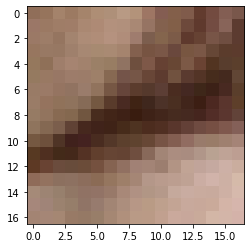

Input image (Up-scale factor 3): 


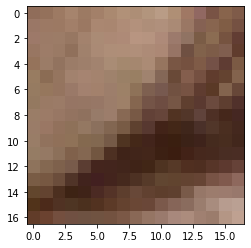

In [272]:
trainExample4 = SuperResolutionDataset("train_data/Set91", 4)
print("Input image (Up-scale factor 4): ")
trainExample4.imshow_input(0)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3)
print("Input image (Up-scale factor 3): ")
trainExample3.imshow_input(0)

Target image: 


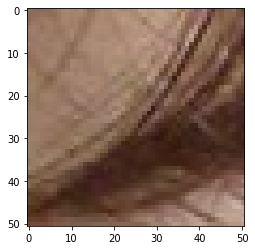

In [0]:
print("Target image: ")
trainExample3.imshow_target(0)

## Network Architecture

In [0]:
import torch.nn as nn
import torch

class SuperResolutionNet(nn.Module):
    def __init__(self, r, activation=nn.Identity()):
        super().__init__()
        self.r = r
        self.activation = activation

        self.deconvolution = nn.PixelShuffle(self.r)

        self.layers = nn.ModuleList([
            nn.Conv2d(3, 64, 5, padding=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 32, 3, padding=1),
        ])

        self.last_layer = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        # self.params = list(self.layers.parameters())

        self.l = len(self.layers) - 1  # The number of hidden layers

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))

        x = self.last_layer(x)  # Don't use the activation on the last convolutional layer

        if not self.training:
          x = self.deconvolution(x)

        return x

## Training Network
Function to train a certain network with a certain data loader and hyperparameters

In [0]:
import os
import time
import math
import datetime

from torch import optim
from . import SuperResolutionNet

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)

def train(net, use_gpu, train_loader, r,
          learning_rate=0.01,
          max_epochs_without_improvement=100,
          max_epochs=30000,
          print_output=True,
          momentum=0.9,
          learning_rate_factor=0.99,
          learning_rate_abs=0.00001,
          beta1=0.9,
          beta2=0.999):

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        if print_output:
          print('Running on gpu')

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()

    optimizer = optim.Adam(
    [
        {"params": net.layers.parameters()},
        {"params": net.last_layer.parameters(), "lr": learning_rate/10},
    ],
    lr=learning_rate,
)

    # Save computer name to use when storing network
    computer_name = "unknown"
    try:
      computer_name = os.environ['COMPUTERNAME']
    except:
      pass

    # Initialize loss.
    lowest_loss = (0, float('inf'))
    previous_loss = float('inf')
    highest_psnr = - float('inf')

    begin_time = time.time()
    minimum_psnr_to_save = 20

    # Start training.
    for epoch in range(max_epochs):
        train_loss = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        mean_psnr = mse_to_psnr(mean_train_loss)

        if previous_loss - mean_train_loss < 0:
          old_learning_rate = optimizer.param_groups[0]['lr']
          optimizer.param_groups[0]['lr']
          new_learning_rate = max(0.0001, learning_rate_factor * old_learning_rate - learning_rate_abs)
          optimizer.param_groups[0]['lr'] = new_learning_rate

          # Learning rate of the last layer should be 10 times lower
          optimizer.param_groups[1]['lr'] = new_learning_rate/10


        previous_loss = mean_train_loss
          

        # Update the lowest loss if necessary.
        if mean_train_loss < lowest_loss[1]:
            #print(f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f} in {time.time() - begin_time:.2f}s #")
            lowest_loss = (epoch, mean_train_loss)
            highest_psnr = mean_psnr
          

            #If the psnr is above some threshold save this new best network.
            if highest_psnr > minimum_psnr_to_save:
                torch.save(net, f'SuperResulutionNet_best_of_run-{computer_name}')

        if epoch % 10 == 0 and print_output:
          
            print(
              f"Epoch: {epoch: >3} in {str(datetime.timedelta(seconds=int(time.time() - begin_time)))}, best epoch so far: Epoch: {lowest_loss[0]: >3} Training Loss: {lowest_loss[1]:.6f} Mean PSNR: {highest_psnr:.2f}, lr={ optimizer.param_groups[0]['lr']:.5f}")


        # If we didn't improve for some amount of epoch, lets stop.
        if epoch > lowest_loss[0] + max_epochs_without_improvement:
            if print_output:
                print(f"No improvement for the last {max_epochs_without_improvement} epochs, so stopping training...")
            break

    net.eval()
    if highest_psnr >= minimum_psnr_to_save:
        network_name = f'SuperResulutionNet_r-{r}_psnr-{int(round(highest_psnr * 100))}__mse-{int(round(lowest_loss[1] * 10000))}-{computer_name}'
        old_file = os.path.join(".", f'SuperResulutionNet_best_of_run-{computer_name}')
        new_file = os.path.join(".", network_name)
        if print_output:
            print(f'Saving best epoch ({lowest_loss[0]}) with loss: {lowest_loss[1]} and psnr: {highest_psnr} as:')
            print(network_name)
        os.rename(old_file, new_file)
    elif print_output:
        print("Not high enough psnr to save the network...")

    return lowest_loss[1]

In [291]:
use_gpu = torch.cuda.is_available()

# Batch size.
bs = 16

# Upscale factor.
r = 3

# Amount of epochs.
epochs = 20

# Getting image data
transform = transforms.Compose([transforms.ToTensor()])  # ,

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)

# Initialize the network.
net = SuperResolutionNet(r, activation=nn.ReLU())

train(net, use_gpu, train_loader, r)

Epoch:  50 in 0:00:10, best epoch so far: Epoch:  50 Training Loss: 0.006712 Mean PSNR: 21.73, lr=0.01000
Epoch:  60 in 0:00:12, best epoch so far: Epoch:  60 Training Loss: 0.006247 Mean PSNR: 22.04, lr=0.01000
Epoch:  70 in 0:00:14, best epoch so far: Epoch:  70 Training Loss: 0.005872 Mean PSNR: 22.31, lr=0.01000
Epoch:  80 in 0:00:16, best epoch so far: Epoch:  80 Training Loss: 0.005582 Mean PSNR: 22.53, lr=0.01000
Epoch:  90 in 0:00:18, best epoch so far: Epoch:  90 Training Loss: 0.005317 Mean PSNR: 22.74, lr=0.01000
Epoch: 100 in 0:00:20, best epoch so far: Epoch: 100 Training Loss: 0.005090 Mean PSNR: 22.93, lr=0.01000
Epoch: 110 in 0:00:22, best epoch so far: Epoch: 110 Training Loss: 0.004880 Mean PSNR: 23.12, lr=0.00999
Epoch: 120 in 0:00:24, best epoch so far: Epoch: 120 Training Loss: 0.004698 Mean PSNR: 23.28, lr=0.00999
Epoch: 130 in 0:00:26, best epoch so far: Epoch: 130 Training Loss: 0.004534 Mean PSNR: 23.43, lr=0.00998
Epoch: 140 in 0:00:28, best epoch so far: Epoc

0.002433761823900008

## Evaluation

In [0]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

# from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_by_name(network_name):
    net = torch.load(network_name)
    evaluate(net)

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)
    
def evaluate(net):
    r = net.r
    print(f"r: {r}")

    use_gpu = torch.cuda.is_available()

    test_set_paths = ["test_data/" + f for f in listdir("test_data")]
#     test_set_paths = ["test_data/Custom"]

    for path in test_set_paths:
        psnr = []
        mse = []
        test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu, testing=True)


        test_loader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)


        for input, target in iter(test_loader):
            if use_gpu:
                input = input.cuda()
                target = target.cuda()

            if input.size()[1] == 1:
                input = input.repeat(1, 3, 1, 1)

            output = net(input)


            if use_gpu:
                input = input.cpu()
                output = output.cpu()
                target = target.cpu()


            bicubic = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.BICUBIC),
                transforms.ToTensor()
            ])
            bicubic_upscaled = bicubic(input[0])

            nearest_neighbour = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.NEAREST),
                transforms.ToTensor()
            ])

            input = nearest_neighbour(input[0])
            # output = torch.clamp(output.detach(), 0, 1)

            if target.size()[1] == 1:
                target = target.repeat(1, 3, 1, 1)

            mse_loss = nn.MSELoss()(output, target).item()
            mse.append(mse_loss)
            psnr.append(mse_to_psnr(mse_loss))

            images = [input, target[0], output.detach()[0], bicubic_upscaled]

        print(f"{path} - avarage psnr: {np.mean(psnr)}, psnr of average mse: {mse_to_psnr(np.mean(mse))}")

    # plt.show()

In [334]:
evaluate(net)

r: 3
test_data/BSD500 - avarage psnr: 26.513302433142208, psnr of average mse: 25.305135923133733
test_data/Set5 - avarage psnr: 29.251275389642963, psnr of average mse: 27.936438576253334
test_data/BSD300 - avarage psnr: 26.6278637523867, psnr of average mse: 25.3310071681516
test_data/Set14 - avarage psnr: 26.31797737340256, psnr of average mse: 25.337559041988587
test_data/SuperTexture - avarage psnr: 24.487856278677857, psnr of average mse: 22.307540565934918


In [336]:
evaluate(net)

r: 3
test_data/BSD500 - avarage psnr: 26.494012059518397, psnr of average mse: 25.2864189330735
test_data/Set5 - avarage psnr: 29.21752743513349, psnr of average mse: 27.90425606306598
test_data/BSD300 - avarage psnr: 26.609591910011968, psnr of average mse: 25.31428614449313
test_data/Set14 - avarage psnr: 26.28821186034873, psnr of average mse: 25.303261110726737
test_data/SuperTexture - avarage psnr: 24.472527774841037, psnr of average mse: 22.293787861574557


In [288]:
evaluate_by_name('SuperResulutionNet_r-3_psnr-2836__mse-15-unknown')

r: 3
test_data/BSD500 - avarage psnr: 26.362028775376668, psnr of average mse: 25.17812778127549
test_data/Set5 - avarage psnr: 28.898014619497935, psnr of average mse: 27.626260223336928
test_data/BSD300 - avarage psnr: 26.478246918008207, psnr of average mse: 25.20898656080558
test_data/Set14 - avarage psnr: 26.091769265120707, psnr of average mse: 25.129386428463512
test_data/SuperTexture - avarage psnr: 24.295404681202378, psnr of average mse: 22.172009585297594


### Finding Hyperparameters
We use the AX framework to find the best hyperparameters for the network. 

In [0]:
!pip3 install ax-platform 

In [10]:
from ax import optimize

def train_evaluate(parameters):
    use_gpu = torch.cuda.is_available()
    bs = 32
    r = 3

    training_set = SuperResolutionDataset('train_data/Set91', r, use_gpu=use_gpu)
    # training_set = SuperResolutionDataset('test_data/BSD500', r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    return train(net, use_gpu, train_loader, r,
                 learning_rate_factor=parameters['learning_rate_factor'],
                 learning_rate_abs=parameters['learning_rate_abs'],
                 print_output=False)


best_parameters, best_values, experiment, model = optimize(
        parameters=[
            # {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
            # {"name": "beta1", "type": "range", "bounds": [0.5, 0.9]},
            # {"name": "beta2", "type": "range", "bounds": [0.9, 0.999]},
            {"name": "learning_rate_factor", "type": "range", "bounds": [0.5, 1.]},
            {"name": "learning_rate_abs", "type": "range", "bounds": [0., 0.0001]}
        ],

        # Booth function
        evaluation_function=train_evaluate,
        objective_name='training-error',
        minimize=True,
    )

print(best_parameters, best_values, experiment, model)

[INFO 04-18 20:34:12] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 04-18 20:34:12] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-18 20:34:12] ax.service.managed_loop: Running optimization trial 1...


2
0.01
0.001


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.

[INFO 04-18 20:49:34] ax.service.managed_loop: Running optimization trial 2...


2
0.01
0.001


[INFO 04-18 21:03:48] ax.service.managed_loop: Running optimization trial 3...


2
0.01
0.001


[INFO 04-18 21:09:51] ax.service.managed_loop: Running optimization trial 4...


2
0.01
0.001


[INFO 04-18 21:21:22] ax.service.managed_loop: Running optimization trial 5...


2
0.01
0.001


KeyboardInterrupt: ignored

In [11]:
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour


render(plot_contour(model=model, param_x='learning_rate_factor', param_y='learning_rate_abs', metric_name='training-error'))
# render(plot_contour(model=model, param_x='lr', param_y='beta1', metric_name='training-error'))
# render(plot_contour(model=model, param_x='beta1', param_y='beta2', metric_name='training-error'))
# render(plot_contour(model=model, param_x='lr', param_y='beta2', metric_name='training-error'))

NameError: ignored

Use the best parameters found by the bayesion optimization to train a network.

In [0]:
net = SuperResolutionNet(r, activation=nn.ReLU())
train(net, use_gpu, train_loader, r,
                 max_epochs=1000,
                 max_epochs_without_improvement=100, 
                 learning_rate=best_parameters['lr'],
                 beta1=best_parameters['beta1'],
                 beta2=best_parameters['beta2'],
                 )
evaluate(net)

Running on gpu
Epoch:   0 in 0.39s, best epoch so far: Epoch:   0 Training Loss: 0.088246 Mean PSNR: 10.54


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.



Epoch: 100 in 32.96s, best epoch so far: Epoch: 100 Training Loss: 0.002135 Mean PSNR: 26.71
Epoch: 200 in 65.27s, best epoch so far: Epoch: 185 Training Loss: 0.001792 Mean PSNR: 27.47
Epoch: 300 in 97.24s, best epoch so far: Epoch: 288 Training Loss: 0.001633 Mean PSNR: 27.87
Epoch: 400 in 129.17s, best epoch so far: Epoch: 394 Training Loss: 0.001551 Mean PSNR: 28.10
Epoch: 500 in 160.99s, best epoch so far: Epoch: 481 Training Loss: 0.001466 Mean PSNR: 28.34
Epoch: 600 in 193.08s, best epoch so far: Epoch: 598 Training Loss: 0.001384 Mean PSNR: 28.59
Epoch: 700 in 224.81s, best epoch so far: Epoch: 690 Training Loss: 0.001367 Mean PSNR: 28.64
Epoch: 800 in 256.64s, best epoch so far: Epoch: 777 Training Loss: 0.001326 Mean PSNR: 28.77
Epoch: 900 in 288.72s, best epoch so far: Epoch: 889 Training Loss: 0.001308 Mean PSNR: 28.84
Saving best epoch (994) with loss: 0.0012854222453745972 and psnr: 28.9095418850852 as:
SuperResulutionNet_r-3_psnr-2891__mse-13-unknown
r: 3
test_data/Set5 